# Example of automatic fitting of anti-crossing

Pieter Eendebak <pieter.eendebak@tno.nl>

In [1]:
# import the modules used in this program:
import sys, os, time
import qcodes
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import scipy.optimize
import cv2
import qtt
import qtt.measurements
from qtt.algorithms.anticrossing import fit_anticrossing, plot_anticrossing
from qtt.data import load_example_dataset

## Load dataset

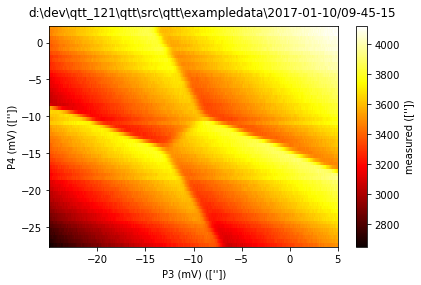

In [2]:
data = load_example_dataset('2017-01-10/09-45-15')

qtt.data.plot_dataset(data, fig=10)

In [3]:
fit_results = fit_anticrossing(data)

straightenImage: size (60, 928) fx 0.1294 fy 2.0000
straightenImage: result size (120, 120) mvx 0.2500 mvy 0.2500
fitModel: score 1618.90 -> 1297.85
fitModel: score 1297.85 -> 1297.85
fit_anticrossing: patch size (60, 60)


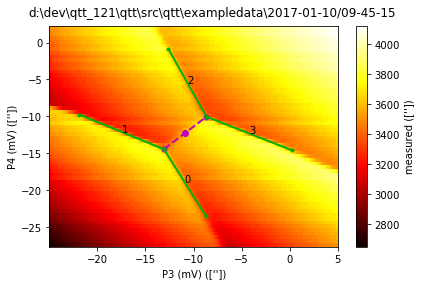

In [4]:
plot_anticrossing(data, fit_results)

In [5]:
print(fit_results)

{'labels': ['P4', 'P3'], 'centre': array([[-10.87200927],
       [-12.26911426]]), 'fitpoints': {'centre': array([[-10.87200927],
       [-12.26911426]]), 'left_point': array([[-13.08187867],
       [-14.47898366]]), 'right_point': array([[ -8.66213987],
       [-10.05924485]]), 'inner_points': array([[-13.08187867, -13.08187867,  -8.66213987,  -8.66213987,
        -24.87058186],
       [-14.47898366, -14.47898366, -10.05924485, -10.05924485,
          2.15483141]]), 'outer_points': array([[ -8.75020813, -21.89998627, -12.61622885,   0.23561125],
       [-23.4921202 ,  -9.76294947,  -0.87419285, -14.62323707]])}, 'fit_params': array([13.99857259, 14.42394567,  3.12522728,  1.12279268,  3.63270088,
        4.30587599,  0.47394414]), 'params': {}}


## Detailed steps (mainly for debugging)

### Pre-process image to a honeycomb

In [6]:
from qtt.algorithms.images import straightenImage
from qtt.utilities.imagetools import cleanSensingImage
from qtt.utilities.tools import showImage as showIm
from qtt.measurements.scans import fixReversal
from qtt.utilities.imagetools import fitModel, evaluateCross

fitBackground: is1d 0, order 3
 checkReversal: 1 (mval 0.1, thr -0.4)
straightenImage: size (60, 928) fx 0.1294 fy 2.0000
straightenImage: result size (120, 120) mvx 0.2500 mvy 0.2500


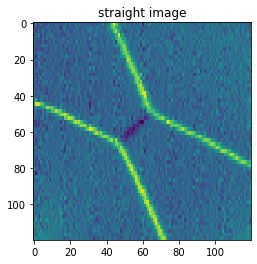

In [7]:
im, tr = qtt.data.dataset2image(data)
imextent = tr.scan_image_extent()
mpl_imextent =tr.matplotlib_image_extent()
istep=.25

imc = cleanSensingImage(im, sigma=0.93, verbose=1)
imx, (fw, fh, mvx, mvy, Hstraight) = straightenImage(imc, imextent, mvx=istep, verbose=2) 

imx = imx.astype(np.float64)*(100./np.percentile(imx, 99)) # scale image

showIm(imx, fig=100, title='straight image')

### Initial input

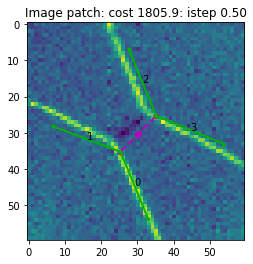

In [8]:
istepmodel = .5
ksizemv = 31
param0 = [(imx.shape[0] / 2 + .5) * istep, (imx.shape[0] / 2 + .5) * istep, \
          3.5, 1.17809725, 3.5, 4.3196899, 0.39269908]
param0e = np.hstack((param0, [np.pi / 4]))
cost, patch, r, _ = evaluateCross(param0e, imx, verbose=0, fig=21, istep=istep, istepmodel=istepmodel)

### Find the anti-crossing

fitModel: score 1618.90 -> 1297.57
calculation time: 2.96 [s]
evaluateCross: patch shape (60, 60)
  add cost for image cc: 2.0


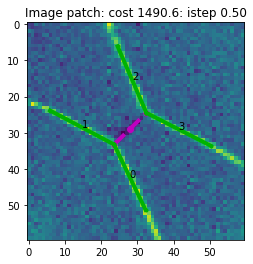

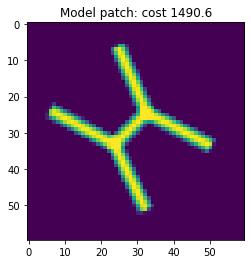

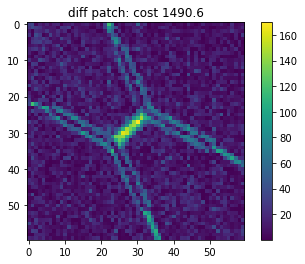

evaluateCross: cost 1490.5538


In [9]:
t0 = time.time()
res = qtt.utilities.imagetools.fitModel(param0e, imx, verbose=1, cfig=10, istep=istep,
                   istepmodel=istepmodel, ksizemv=ksizemv, use_abs=True)
param = res.x
dt = time.time() - t0
print('calculation time: %.2f [s]' % dt)

cost, patch, cdata, _ = evaluateCross(param, imx, verbose=1, fig=25, istep=istep, istepmodel=istepmodel, linewidth=4)

### Show orthogonal line (for polarization scan)

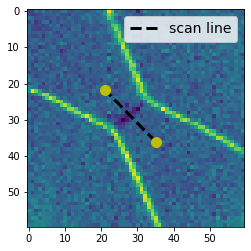

In [10]:
showIm(patch, fig=25)
ppV, ccV, slopeV = qtt.utilities.imagetools.Vtrace(cdata, param, fig=25)